# 環境設定
TGS定序資料將使用由PacBio出品之[pb-16S-nf](https://github.com/PacificBiosciences/pb-16S-nf)進行分析，pb-16S-nf透過nextflow建立自動分析流程，其中結合了seqkit、Qiime2、Krona等多種套件。不過使用者只要安裝nextflow即可，不必自行安裝以上套件，執行pb-16S-nf的環境配置檔皆會在執行pb-16S-nf時自動下載並使用，可分為conda以及singularity環境，下面將詳細介紹。

請閱讀並執行`install_package.ipynb`

完成上述步驟後，將新建立之`HMP_project`環境的binary執行檔路徑寫入環境變數中

In [1]:
import os
Add_Binarry_Path='\
~/.conda/envs/HMP_project/bin/:\
/opt/ohpc/Taiwania3/libs/singularity/3.10.2/bin/'
os.environ['PATH']=Add_Binarry_Path+':'+os.environ['PATH']

# 下載pb-16S-nf主程式 (請在HPC登入節點下載)

In [2]:
!git clone https://github.com/PacificBiosciences/pb-16S-nf.git

Cloning into 'pb-16S-nf'...
remote: Enumerating objects: 1279, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 1279 (delta 88), reused 147 (delta 84), pack-reused 1121
Receiving objects: 100% (1279/1279), 17.79 MiB | 19.86 MiB/s, done.
Resolving deltas: 100% (807/807), done.


進入pb-16S-nf目錄，並創建一個專案目錄

In [3]:
%cd pb-16S-nf

/home/s4107037054/HMP_project/pb-16S-nf


![pb-16S-nf workflow](https://raw.githubusercontent.com/PacificBiosciences/pb-16S-nf/main/misc/pipeline_workflow.png)
[pb-16S-nf](https://github.com/PacificBiosciences/pb-16S-nf)是專為TGS定序分析之nextflow pipeline，此pipeline利用多種套件處理TGS定序資料，但使用者只需在環境中安裝nextflow套件即可，不須額外安裝上圖列出之所有套件，當執行nextflow時，系統將自動安裝所需套件至`$HOME/nf_conda/`可pb-16S-nf目錄下之`nextflow.config`進行修改。選擇操作方式，設定`--profile`參數(預設是conda)。
```
-profile singularity
-profile conda
```
本次將使用singularity執行pb-16S-nf，singularity具備輕量、快速啟動、方便部署、容易遷移的特性，使用者只須下載singularity映像檔(image)即可使用特定環境。

# 開始分析之前
配置TGS分析需要的檔案，包含`singularity image`，以及`database` folder，由於這類檔案過於龐大，無法透過git與pb-16S-nf主程式一併下載。透過以下兩種方式完成配置:

## 方法1. 透過pb-16S-nf指令下載databases，並執行測試檔將所需image下載完成(在HPC登入節點執行)

In [ ]:
nextflow run main.nf --download_db -profile singularity

- `nextflow run main.nf --download_db -profile singularity` # 安裝databases folder

In [ ]:
echo -e "sample-id\tabsolute-filepath\ntest_data\t$(readlink -f test_data/test_1000_reads.fastq.gz)" > test_data/test_sample.tsv
nextflow run main.nf \
--input test_data/test_sample.tsv \
--metadata test_data/test_metadata.tsv \
-profile singularity \
--outdir results

- `echo -e "sample-id\tabsolute-filepath\ntest_data\t$(readlink -f test_data/test_1000_reads.fastq.gz)" > test_data/test_sample.tsv`: Create sample TSV for testing
- `nextflow run main.nf --input test_data/test_sample.tsv 
--metadata test_data/test_metadata.tsv -profile singularity 
--outdir results`: 使用範例檔測試，並將image安裝完畢

## 方法2. 直接將已下載之相關檔案複製到自己的pb-16S-nf目錄中

In [20]:
!cp -r /work/s4107037054/biodata/pb-16S-nf-database-0.7v/databases ./
!cp -r /work/s4107037054/biodata/pb-16S-nf-database-0.7v/singularity $HOME/nf_conda/

# 建立專案目錄，並上傳原始資料

In [6]:
project_name = "project_1"
!mkdir -p {project_name}/seqs
!mkdir -p {project_name}/results

- `project_1/raw`: 放置序列原始資料之目錄，原始序列須為.fastq.gz。
- `project_1/results`: 分析結果輸出路徑。
- `gen_ma.bash`, `tail_name.txt`: 自動產生manifast.tsv的執行檔

## 上傳序列原始檔案至`seqs`，並執行下列指令產生manifest

In [12]:
import os, sys
tail = ".fastq.gz" #forward序列檔案的結尾

seqs_folder = f"{project_name}/seqs/" #原始序列存放的位置
abs_seqs_folder = os.path.abspath(seqs_folder)
seq_files = os.listdir(seqs_folder)
manifest = {} #以字典的形式儲存sample-id(key)和absolute-filepath(value)

if tail != "":
    for seq in seq_files:
        seq_basename = seq.replace(tail,"")
        seq_abs_path = f"{abs_seqs_folder}/{seq}" # seq的絕對路徑
        manifest[seq_basename] = seq_abs_path
    sorted_manifest = {}# 重新排列manifest，以basename排序
    for sample_id in sorted(list(manifest.keys())):
        sorted_manifest[sample_id] = manifest[sample_id]
    with open(f"{project_name}/manifest.tsv", "w") as manifest_w:
        manifest_w.write("sample-id\tabsolute-filepath\n") # header
        for sample_id, absolute_filepath in sorted_manifest.items():
            manifest_w.write(f"{sample_id}\t{absolute_filepath}\n")
        print(f"manifest.tsv already generate in {os.getcwd()}/{project_name}/seqs/")
else:
    sys.exit("ERROR: Please set tails.")

manifest.tsv already generate in /home/s4107037054/HMP_project/pb-16S-nf/project_1/seqs/


## 最後再上傳metadata.tsv

# nextflow執行pb-16s-nf可調整之參數及其說明

In [13]:
!nextflow run main.nf --help

[0.001s][warning][os,container] Duplicate cpuset controllers detected. Picking /sys/fs/cgroup/cpuset, skipping /etc/slurm/cgroup/cpuset.
N E X T F L O W  ~  version 23.04.1
Launching `main.nf` [determined_boltzmann] DSL2 - revision: 8e2e3ee2a4

  Usage:
  This pipeline takes in the standard sample manifest and metadata file used in
  QIIME 2 and produces QC summary, taxonomy classification results and visualization.

  For samples TSV, two columns named "sample-id" and "absolute-filepath" are
  required. For metadata TSV file, at least two columns named "sample_name" and
  "condition" to separate samples into different groups.

  nextflow run main.nf --input samples.tsv --metadata metadata.tsv \
    --dada2_cpu 8 --vsearch_cpu 8

  By default, sequences are first trimmed with cutadapt. If adapters are already trimmed, you can skip 
  cutadapt by specifying "--skip_primer_trim".

  Other important options:
  --front_p    Forward primer sequence. Default to F27. (default: AGRGTTYGATYMTGG

上面是在描述pb-16S-nf的使用方式，有幾項重點必須知道:
- `--input ...`: manifast.tsv檔案位置。
- `--metadata ...`: metadata.tsv檔案位置。
- `-profile ...`: 以conda或是singularity執行pb-16s-nf，在HPC中建議使用singularity。
- `manifast.tsv`裡面的column一定要取作`sample-id`和`absolute-filepath`分別記錄樣本的ID及其檔案之絕對路徑。`metadata.tsv`至少需要兩個columns分別為`sample_name`(注意，是_而非-)以及`condition`分別記錄樣本的名稱及其分組依據(也可以透過參數`--colorby ...`設定分組的column)。
- 預設在cutadapt步驟(詳細可點開main.nf查看`第253行process cutadapt`)會切除序列引子，引子預設為`AGRGTTYGATYMTGGCTCAG`和`AAGTCGTAACAAGGTARCY`，若您使用之序列屬於non-primer read，可設定`--skip_primer_trim`跳過去除引子步驟。

其他參數設定:
- `--front_p ...`: 正向引子序列。默認值是 F27 引子的序列(AGRGTTYGATYMTGGCTCAG)。設定`--skip_primer_trim`跳過此步驟。
- `--adapter_p ...`: 反向引子序列。默認值是 R1492 引子的序列(AAGTCGTAACAAGGTARCY)。設定`--skip_primer_trim`跳過此步驟。
- `--filterQ ...`: 過濾出平均qulity score高於此 Q 值的輸入序列(預設值為 20)。
- `--downsample ...`: 限制同樣read出現頻率不超過N(預設off)。
- `--max_ee ...`: DADA2 的 max_EE 參數。預期錯誤數高於此值的序列將被丟棄(預設值為 2)。
- `--minQ ...`: DADA2 的 minQ 參數。任何鹼基quality score低於此分數的序列將被刪除(預設值為 0)。
- `--min_len ...`: 將小於這個序列長度的read移除(預設1000)。
- `--max_len ...`: 將大於這個序列長度的read移除(預設1600)。
- `--pooling_method ...`: DADA2的denoised方法。
- `--min_asv_totalfreq ...`: 任何ASV在所有樣本中的總頻率必須高於此閾值，濾掉不符合此條件的ASV。將其設置為0以禁用。(預設值為 5)。
- `--min_asv_sample ...`: ASV至少出現在N個sample中，否則去除。將其設置為0以禁用。(預設值為 1)。
- `--rarefaction_depth ...`: 稀疏曲線中的取樣深度。
- `--dada2_cpu ...`: 執行dada2之cpu數量(預設為 8)。
- `--vsearch_cpu ...`: 執行vsearch之cpu數量(預設為 8)。
- `--cutadapt_cpu ...`: 執行cutadapt之cpu數量(預設為 16)。
- `--outdir ...`: 分析結果之輸出位置。
- `--vsearch_db`,`--vsearch_tax`,`--silva_db`,`--gtdb_db`,`refseq_db`: 各種資料庫及classifier的位置，預設是使用`databases`目錄下的資料。
- `--skip_primer_trim`: 原始數列若已切除引子，則設定此參數跳過切除引子步驟。
- `--skip_nb`: 跳過使用Naive-Bayes分類器，僅使用VSEARCH(預設false)。
- `--colorby ...`: 預設為`condition`，影響結果報表中樣本的分組依據。
- `--run_picrust2 ...`: 運行PICRUSt2流程。注意，使用16S進行的PICRUSt2的途徑推斷尚未經過系統測試。默認為false。
- `--download_db`: 僅下載用於分類的資料庫，不運行流程。資料庫將下載到Nextflow目錄中的`databases`目錄中。
- `--resume`: 若pipeline因為一些錯誤中斷了(如網路問題無法下載image)，重新執行時可在最後加上此參數，將從快取存取不需重複執行的步驟。

# 依照原始資料大小，確認運算資源
節錄自[pb-16S-pb document](https://github.com/PacificBiosciences/pb-16S-nf#run-time-and-compute-requirements-)，建議選擇使用**32 CPU**以上的環境: **We recommend at least 32 CPUs for most sample type. The run time depends highly on the complexity of the samples in addition to the total number of reads. Shown here are examples of run time for some data that was tested with this pipeline using 32 CPUs:**
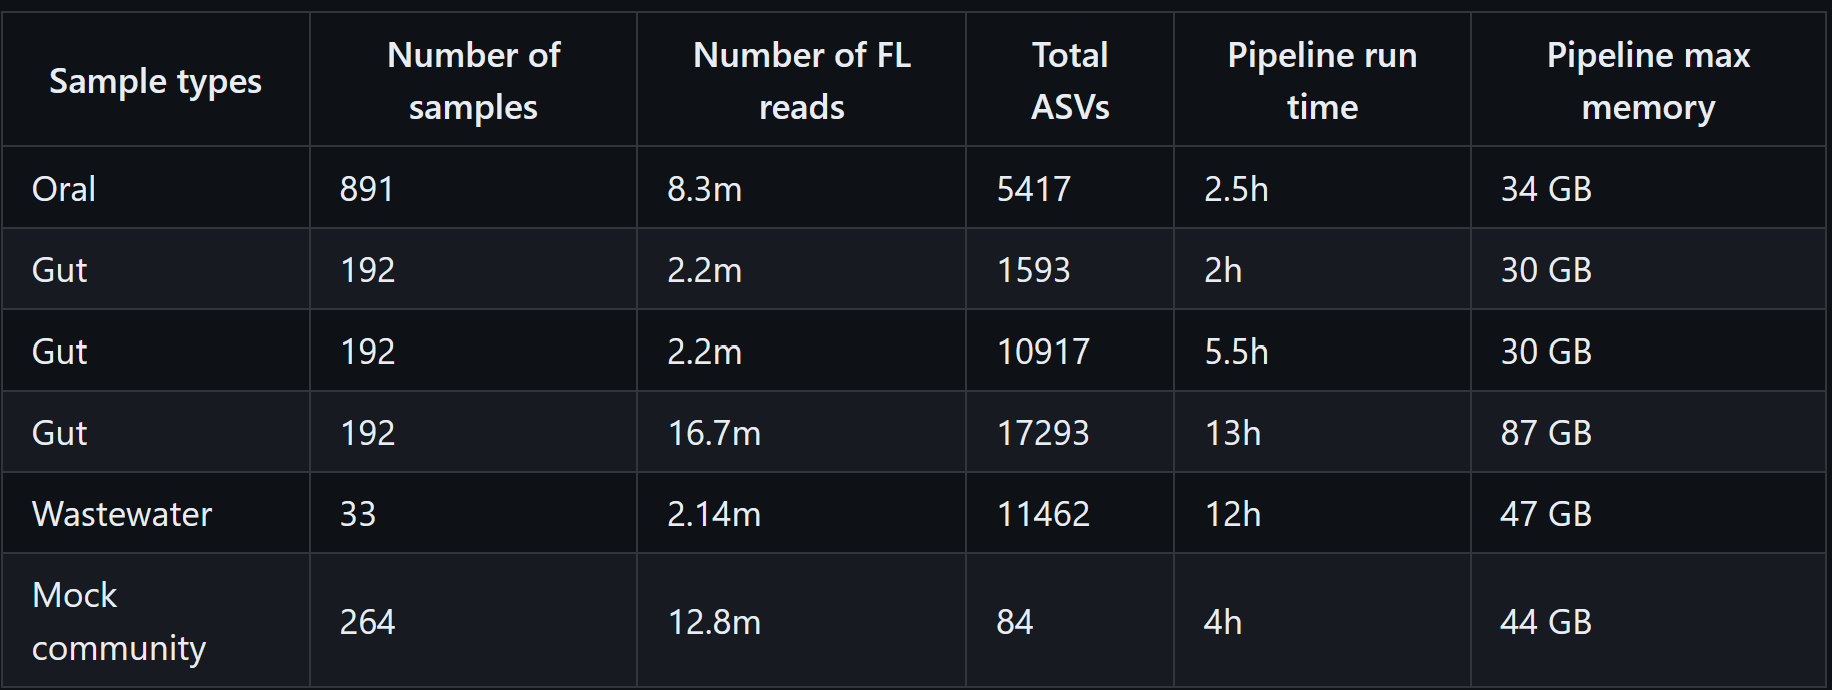
依照上述需求，選擇相應的HPC運算節點。

透過編寫slurm排程確認運算節點後，執行slurm排程 - [國網中心生醫核心設施 - 台灣杉三號生醫專用節點使用說明](https://man.twcc.ai/@Ldk_QYrOR2yo3m8Cb1549A/rkegDKslF#%E5%85%AC%E7%94%A8%E8%BB%9F%E9%AB%94%E5%AE%89%E8%A3%9D%E4%BD%8D%E7%BD%AE)

## 請於`pb-16S-nf`建立一個`slurm_job.sh`，並依照core數與記憶體搭配，編寫工作排程，範例如下:
```
#!/usr/bin/sh
#SBATCH -A MST109178        # Account name/project number
#SBATCH -J TGS_56cpu_372G         # Job name
#SBATCH -p ngs372G           # Partition Name 等同PBS裡面的 -q Queue name
#SBATCH -c 56               # 使用的core數  請參考Queue資源設定 
#SBATCH --mem=372g           # 使用的記憶體量 請參考Queue資源設定
#SBATCH -o project_1/out.log          # Path to the standard output file 
#SBATCH -e project_1/err.log          # Path to the standard error ouput file
#SBATCH --mail-user=2303108@narlabs.org.tw    # email
#SBATCH --mail-type=BEGIN,END              # 指定送出email時機 可為NONE, BEGIN, END, FAIL, REQUEUE, ALL

nextflow run main.nf \
--input project_1/manifest.tsv \
--metadata project_1/metadata.tsv \
-profile singularity \
--outdir project_1/results \
--dada2_cpu 56 \
--cutadapt_cpu 56 \
--vsearch_cpu 56
```
---
- `nextflow run`: nextflow執行`main.nf`
- `--input ...`: manifest檔案路徑
- `--metadata ...`: metadata檔案路徑
- `-profile ...`: 使用singularity/conda執行pb-16S-nf
- `--outdir ...`: 檔案輸出路徑
- `--dada2_cpu ...`: 執行dada2之cpu數量(預設為 8)。
- `--vsearch_cpu ...`: 執行vsearch之cpu數量(預設為 8)。
- `--cutadapt_cpu ...`: 執行cutadapt之cpu數量(預設為 16)。

## 依照Partition修改`nextflow.config`

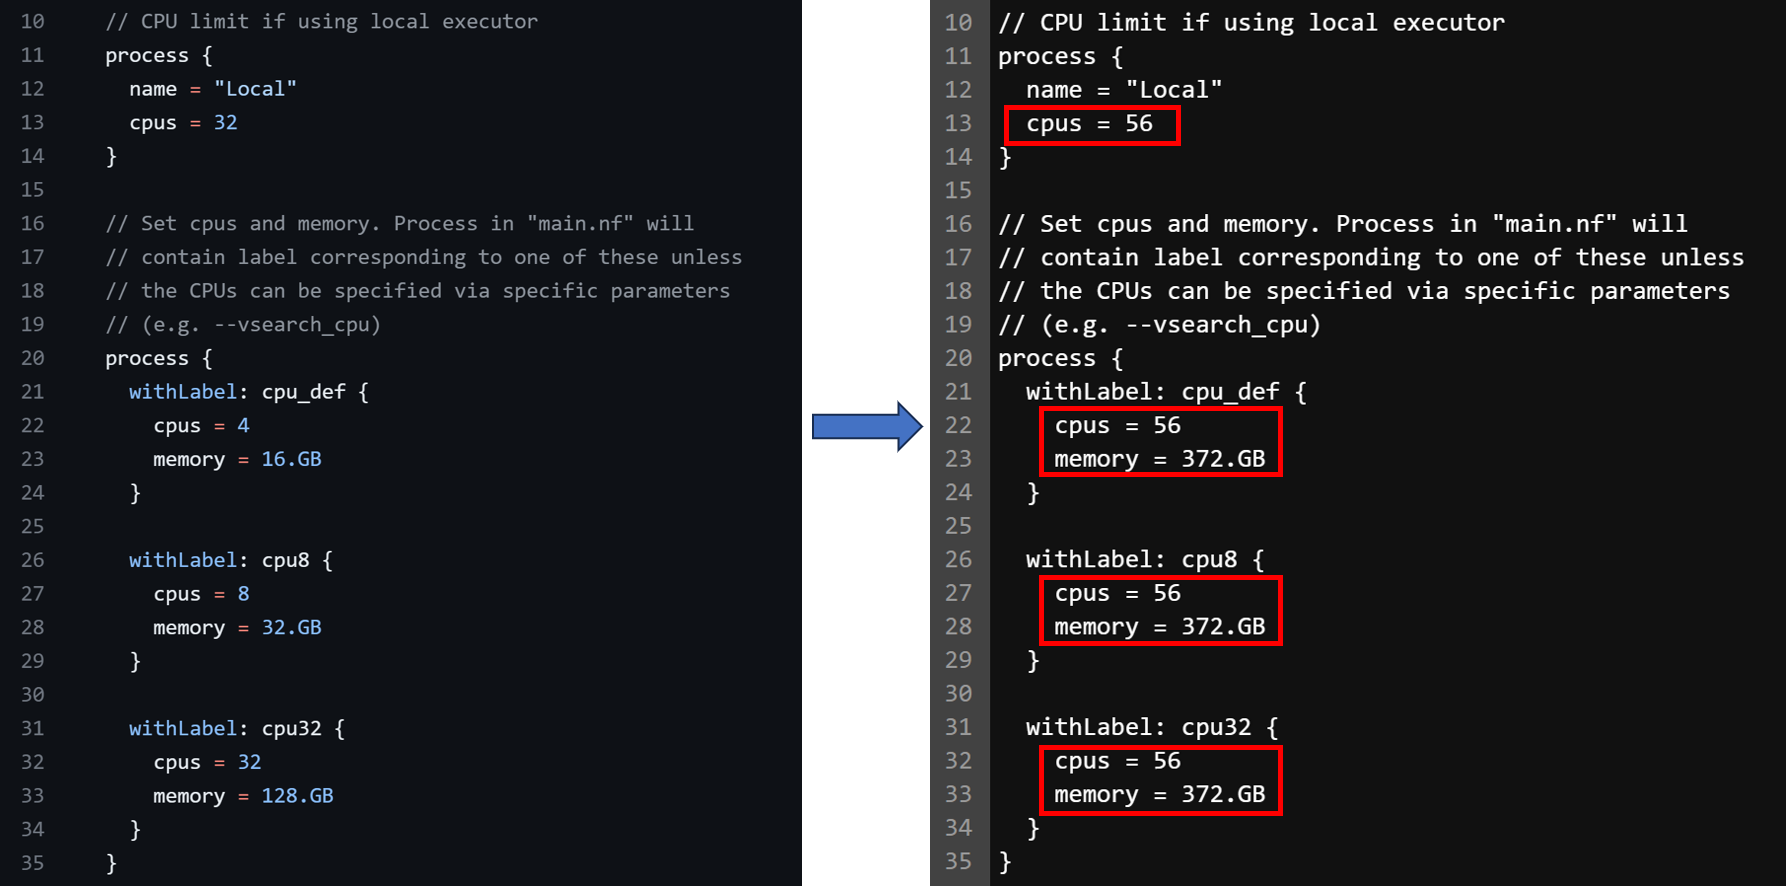

## 送出job

In [15]:
!sbatch slurm_job.sh

Submitted batch job 6865684


## 查看目前運行的slurm排程

In [18]:
!squeue -u s4107037054

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON) 
           6865684   ngs372G TGS_56cp s4107037  R       0:02      1 cpn3892 
           6863079   ngs372G _t3jbio_ s4107037  R    6:17:46      1 cpn3858 


## 停止並刪除排程

In [113]:
!scancel 6764054     

# **ERROR大全**

## ERROR in CONDA

- 原因: 網路無法連線到conda配置檔的下載位置
- 解決方案: 1.確認不是在運算節點進行下載。 2.改用singularity。 3.更改miniconda的權限，不一定能解決(chmod -r 755 miniconda3/) 4.有時候conda環境會跟目前已存在快取中的環境衝突(可能來自上一個workflow所產生的)，使用`conda clean -a`刪除快取中存在的conda套件。
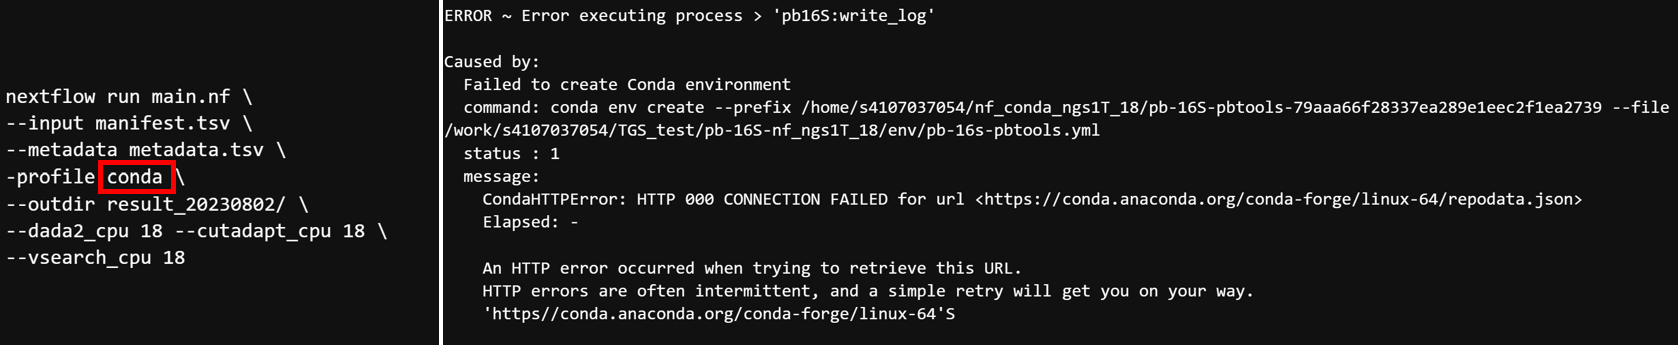

## ERROR in singularity image pull
- 原因: 讀不到image檔，同時也無法下載image。第一次使用時，pb-16S-nf會自動下載需要的image (\*運算節點無法下載檔案)，確認在能下載檔案的環境執行，或是將需要用到的image檔先存放至`%HOME/nf_conda/singularity/`。
- 解決方案: 1.在能下載image的環境先下載好。 2.將已下載之image移動至`%HOME/nf_conda/singularity/` (詳細可參閱上面步驟)
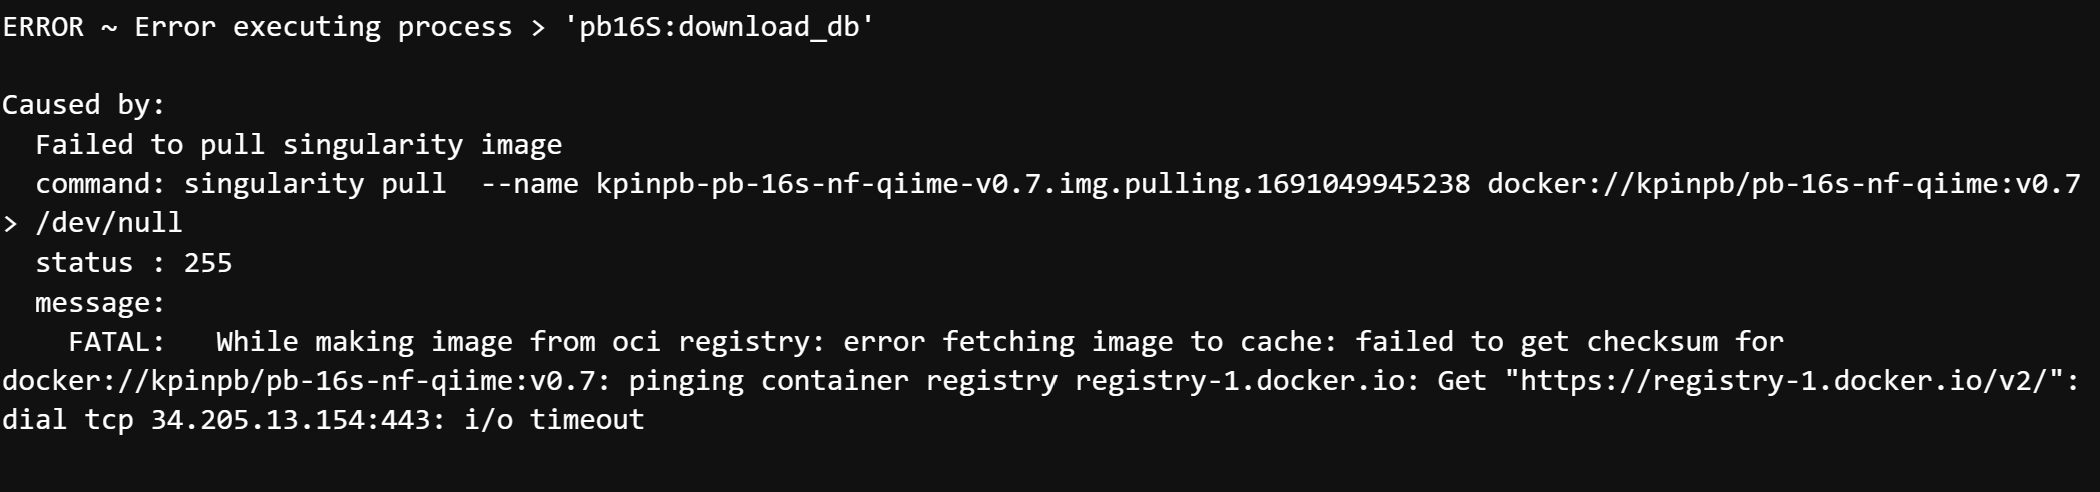

## ERROR in dada2
- 原因: 進入dada2之前序列就已經在前面步驟被篩選掉了，可能序列品質差，也有可能引子設定錯誤導致引子切除後剩餘片段太短。
- 解決方案: 1.確認引子序列，並於`--front_p`和`--adapter_p`參數設定，若原始序列已切除引子則設定`--skip_primer_trim`。 2.更改`--max_ee`以及`--filterQ`參數，放寬篩選條件。
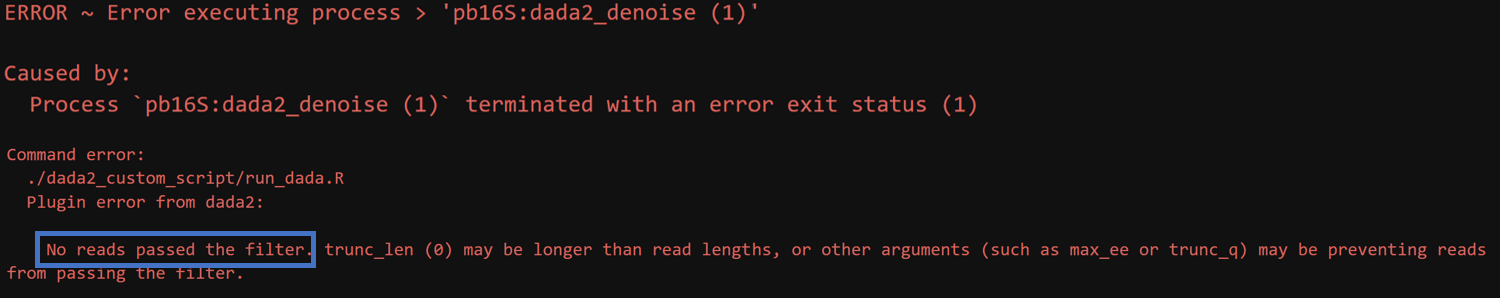

## ERROR in qiime2_phylogeny_diversity 

- 原因: 可能因為[memory不足](https://forum.qiime2.org/t/plugin-error-from-phylogeny-qiime2-2022-2/23728)
- 解決方法: 1.確定使用運算資源足夠的Partition，若本機memory不足，可以利用TWCC執行。 2.修改`nextflow.config`中的參數設定，並更改`main.nf`主程式中process的lab。

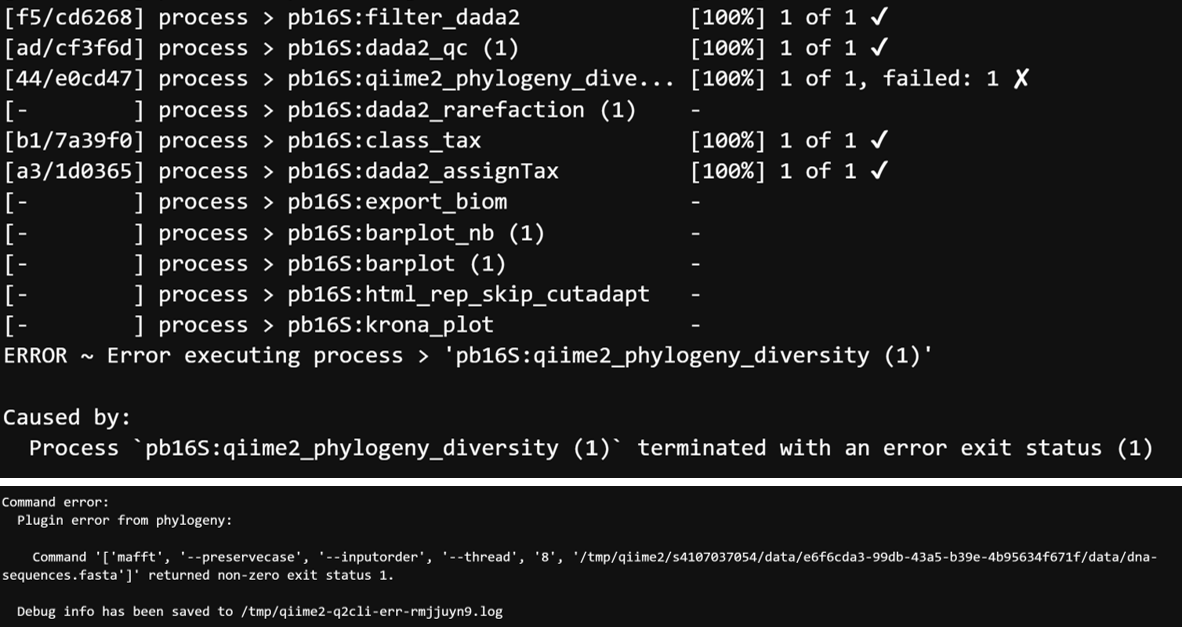
`nextflow.config`:
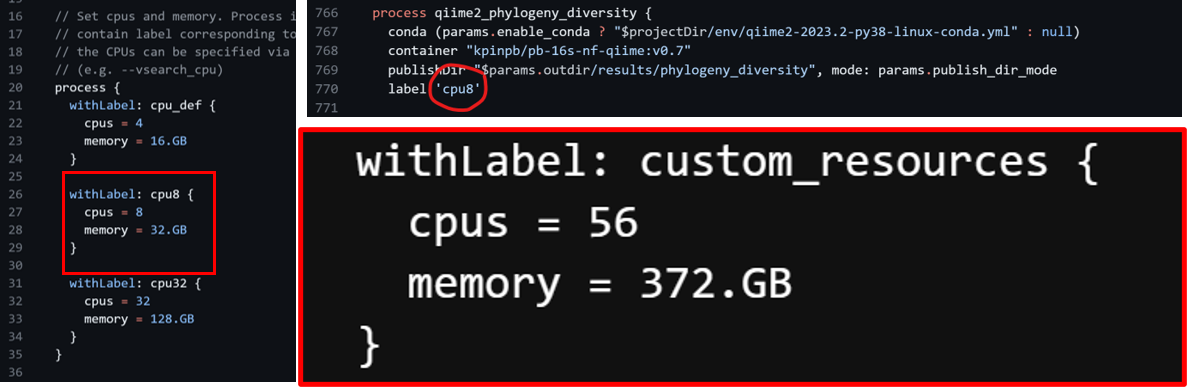
`nextflow.config`中新增足夠運算資源的label，修改`main.nf`中`qiime2_phylogeny_diversity` process的 `label`


## ERROR in HTML report
**Error in FUN()...: object 'condition' not found**

- 原因: `--colorby ...`預設是`condition`，也就是html output會按照metadata中condition這個column的特徵對樣本進行分組，但metadata中找不到`condition`。
- 解決方法: 更改`--colorby ...`成metadata中存在的column，或是將metadata欲作為分組依據的column name改成`condition`

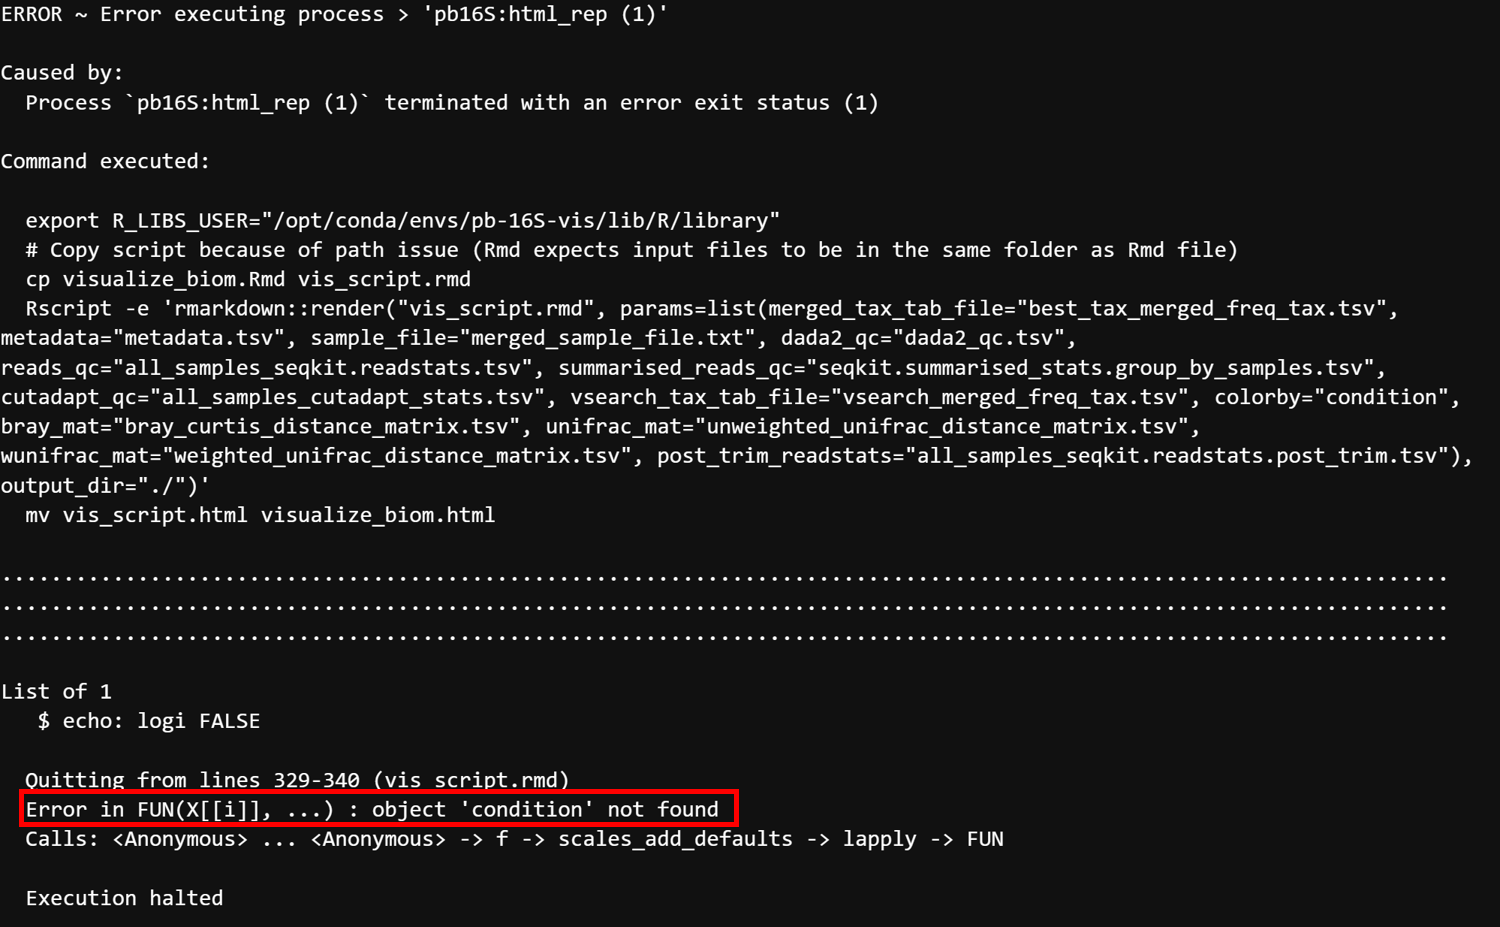

## ERROR file exist
**Report or Timeline file already exists**

- 原因: `nextflow.config`設定輸出檔案無法覆寫，若檔案已存在則終止
- 解決方法: 更改檔案輸出目錄，或是更改`nextflow.config`，在report及timeline加入`overwrite = True`
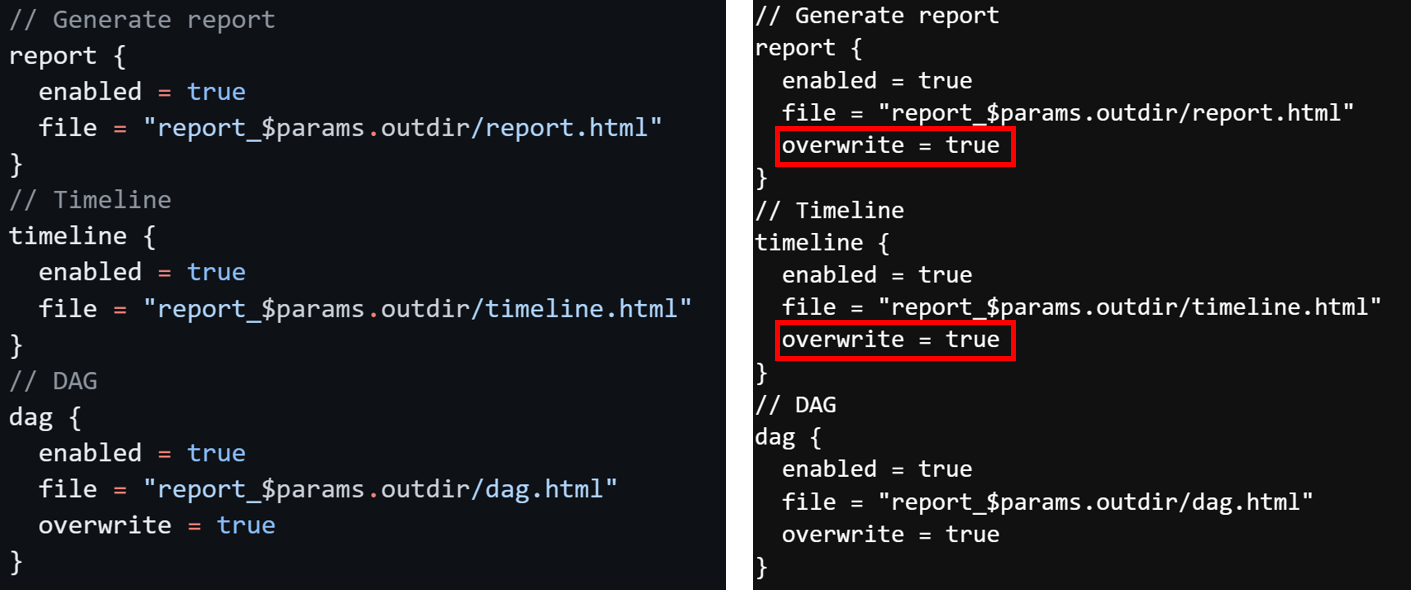